In [2]:
import pandas as pd
from datetime import date, datetime
import os
import sys
import argparse
import random
import pickle
import pprint
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR

from utils import maskedMSE, maskedMSETest, maskedMSEFinalTest

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from stp_r_model import STP_R_Net
from stp_g_model import STP_G_Net
from stp_gr_model import STP_GR_Net

from stp_gr_dataset import STP_GR_Dataset

import math
import time
from plot_helper import find_files, traj_plot_by_plt, x_magnitude, create_new_dir
import os.path as osp

import matplotlib.pyplot as plt
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage


In [3]:
traj_csv = "data_us101/trajectories-0805am-0820am.csv"
traj_df = pd.read_csv(traj_csv)
vid = 337
start_frame,end_frame = 1826,2085
vid_traj = traj_df[(traj_df['Frame_ID'] >= start_frame) & (traj_df['Frame_ID'] <= end_frame) & (traj_df['Vehicle_ID'] == vid)][['Local_X', 'Local_Y']].values
nbr_ids = traj_df[(traj_df['Frame_ID'] >= start_frame) & (traj_df['Frame_ID'] <= end_frame)]['Vehicle_ID'].values
ego_df = traj_df[(traj_df['Frame_ID'] >= start_frame) & (traj_df['Frame_ID'] <= end_frame) & (traj_df['Vehicle_ID'] == vid)]

nbr_ids = set(nbr_ids.flatten())
all_live_nbr_ids = []
for nbr_id in nbr_ids:
    nbr_df = traj_df[(traj_df['Frame_ID'] >= start_frame) & (traj_df['Frame_ID'] <= end_frame) & (traj_df['Vehicle_ID'] == nbr_id)]
    if (len(nbr_df) == end_frame-start_frame+1):
        all_live_nbr_ids.append(nbr_id)
        
print("all live nbr ids:",all_live_nbr_ids)



def get_nbrID_one_lane(frm_id, lane='left'):
    
    
     # 对应帧和id的y坐标以及lane 的id
    ego_y, ego_lane = ego_df[ego_df['Frame_ID'] == frm_id][['Local_Y', 'Lane_ID']].values[0]

    #同一帧内左侧车道的id以及y 坐标
    if lane == 'left':
        vehs_tar_lane = traj_df[(traj_df['Frame_ID'] == frm_id) & (traj_df['Lane_ID'] == int(ego_lane - 1))][['Vehicle_ID', 'Local_Y']].values

    #同一帧内右侧车道的id以及y 坐标
    if lane == 'right':
        vehs_tar_lane = traj_df[(traj_df['Frame_ID'] == frm_id) & (traj_df['Lane_ID'] == int(ego_lane + 1))][['Vehicle_ID', 'Local_Y']].values
    if vehs_tar_lane.size == 0:
        return [0]

    # 把y坐标转变为与ego_y的绝对距离差，然后把距离差最小的作为中间车辆
    vehs_tar_lane[:, 1] = abs(vehs_tar_lane[:, 1] - ego_y)  # the longitudinal distance
    tar_mid_idx = np.where(vehs_tar_lane[:, 1] == np.min(vehs_tar_lane[:, 1]))[0][0]
    tar_mid_vid = vehs_tar_lane[:, 0][tar_mid_idx]
    tar_pre_vid, tar_fol_vid =traj_df[(traj_df['Frame_ID'] == frm_id) & (traj_df['Vehicle_ID'] == tar_mid_vid)][['Preceeding','Following']].values[0]
    return tar_mid_vid,tar_pre_vid,tar_fol_vid

nbr_lane_ids = []
pre_fol_ids = ego_df[['Preceeding','Following']].values
pre_fol_ids = set(pre_fol_ids.flatten())
for i in pre_fol_ids:
    nbr_lane_ids.append(i)
    
for l in ("left","right"):
    for frm_id in range(start_frame,end_frame+1):
        nbrs_3 = get_nbrID_one_lane(frm_id,l)
        for nbr in nbrs_3:
            nbr_lane_ids.append(int(nbr))

nbr_lane_ids = set(nbr_lane_ids)
print(nbr_lane_ids)
print([i for i in nbr_lane_ids if i in all_live_nbr_ids])
# # vid_traj1 = traj_df[(traj_df['Frame_ID'] == start_frame)][['Local_X', 'Local_Y']].values
# print(vid_traj,vid_traj.shape)

all live nbr ids: [289, 290, 291, 294, 295, 297, 299, 301, 302, 305, 306, 307, 308, 311, 312, 314, 315, 316, 317, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 350, 351, 352, 353, 354, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 372, 373, 374, 375, 376, 378, 379, 380, 381, 385, 386]
{352, 353, 323, 328, 329, 331, 332, 336, 338, 339, 340, 341, 342, 343, 344, 346, 347}
[352, 353, 323, 328, 329, 331, 332, 336, 338, 339, 340, 341, 342, 343, 344, 346, 347]


[337, 352, 353, 323, 328, 329, 331, 332, 336, 338, 339, 340, 341, 342, 343, 344, 346, 347]
(18, 260, 2)
[[[ 5.20292688e-02  6.17356968e+00]
  [ 1.44040245e-01  1.17861771e+01]
  [ 1.25525478e-01  1.76708167e+01]
  ...
  [ 9.65258306e-02  4.59830863e+01]
  [ 7.04104506e-02  5.26748313e+01]
  [ 6.85201772e-02  5.92690195e+01]]

 [[ 2.30463694e-01  5.06012718e+00]
  [ 1.58677669e-01  1.04233091e+01]
  [ 2.10515621e-01  1.60367630e+01]
  ...
  [ 3.51158544e-01  4.01460379e+01]
  [ 3.51837354e-01  4.46574463e+01]
  [ 2.97979123e-01  5.02186603e+01]]

 [[ 2.12481444e-02  2.99109301e+00]
  [ 2.82113776e-02  6.02210742e+00]
  [ 5.47196660e-02  9.06902376e+00]
  ...
  [ 3.17513068e-01  2.60839474e+01]
  [ 4.57463429e-01  2.95058548e+01]
  [ 6.08189621e-01  3.38263446e+01]]

 ...

 [[-8.60550580e-02  3.98498467e+00]
  [-1.16539035e-01  7.55623296e+00]
  [-1.13189312e-01  1.08357758e+01]
  ...
  [-2.99344555e-01  2.73670830e+01]
  [-2.99917704e-01  3.11850709e+01]
  [-3.00797846e-01  3.50076911e+

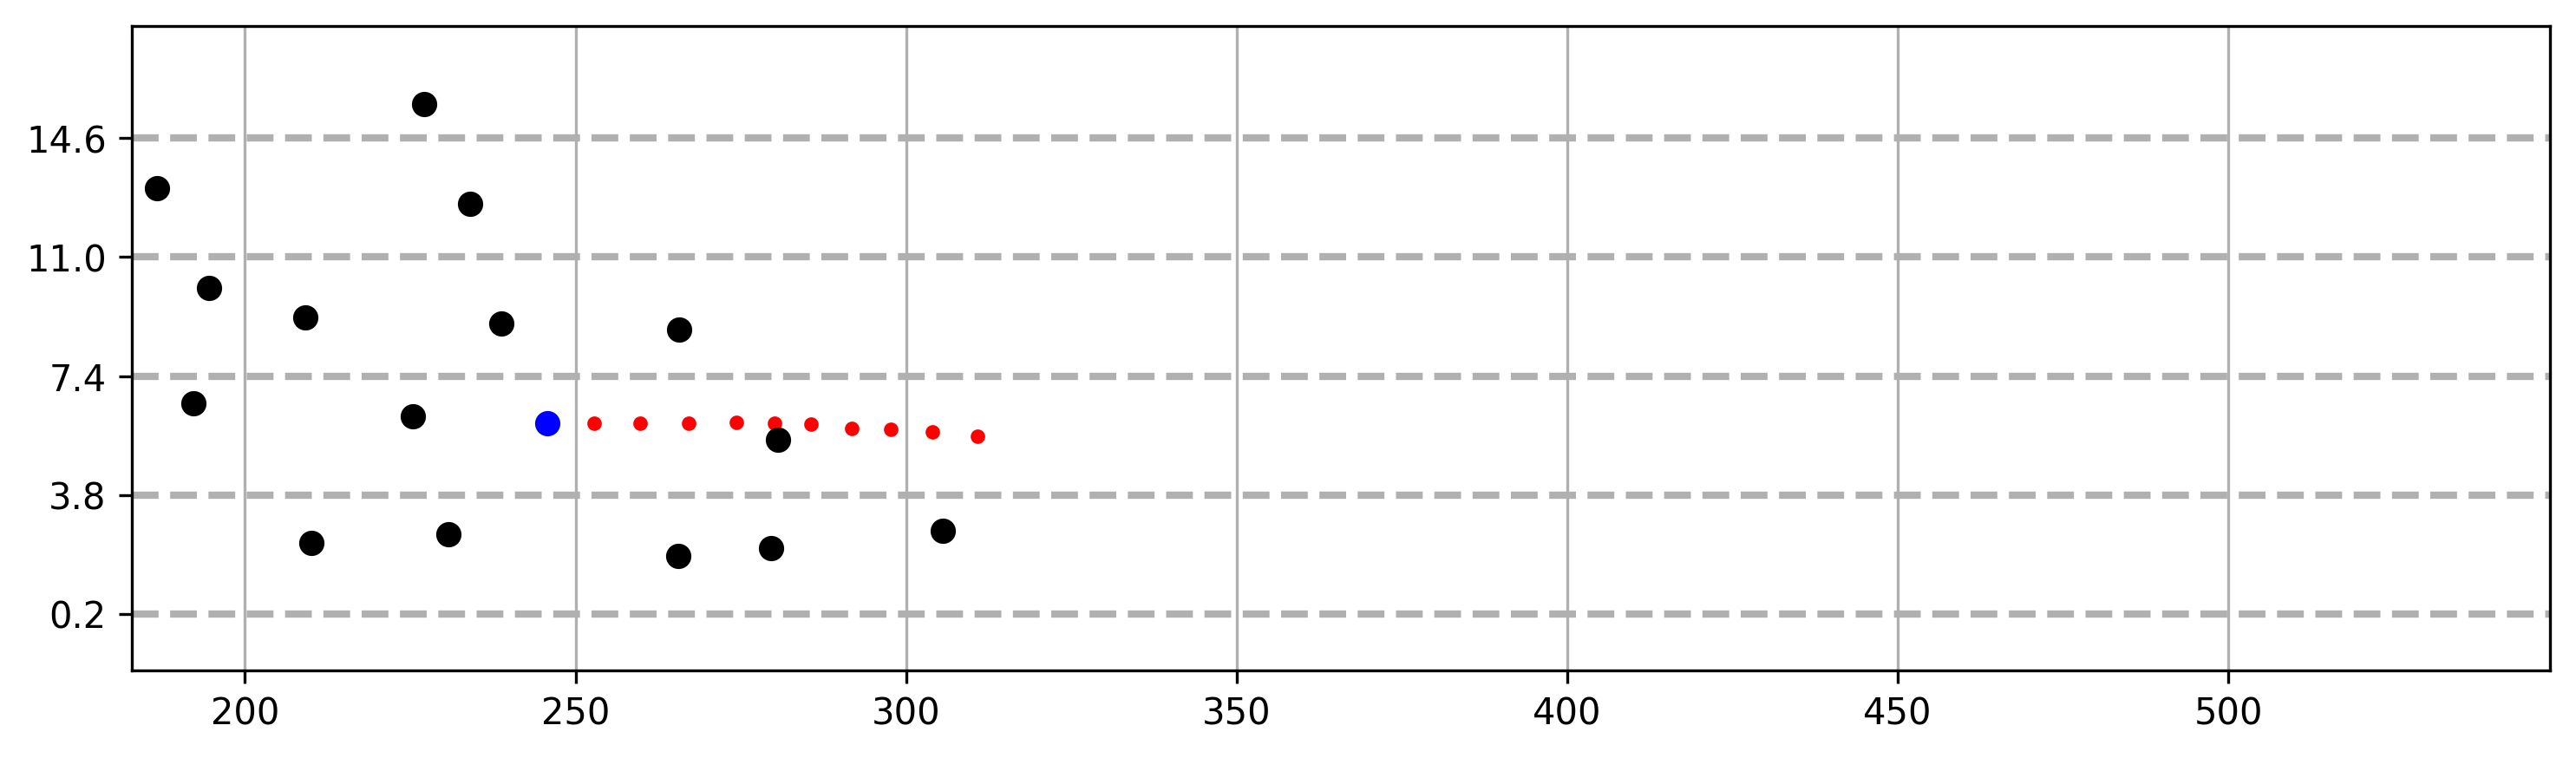

Moviepy - Building video imgs/my_animation3.mp4.
Moviepy - Writing video imgs/my_animation3.mp4



Moviepy - Done !
Moviepy - video ready imgs/my_animation3.mp4


In [21]:
import pickle
final_nbr_ids = [vid] + [i for i in nbr_lane_ids if i in all_live_nbr_ids]
print(final_nbr_ids)
hists = np.zeros([len(final_nbr_ids),len(vid_traj),2])
for i in range(len(final_nbr_ids)):
    hist =  traj_df[(traj_df['Frame_ID'] >= start_frame) & (traj_df['Frame_ID'] <= end_frame) & (traj_df['Vehicle_ID'] == final_nbr_ids[i])][['Local_X', 'Local_Y']].values
    hists[i] = hist
print(hists.shape)

hists = hists* 0.3048
duration = 26

fig, ax = plt.subplots(figsize=(10,4),dpi=300)
fig.set_tight_layout(True)
ax.set_aspect(5)
# plt.ylim(-1.2, 13.2)
major_ticks = np.arange(0.2, 18, 3.6)
# minor_ticks = np.arange(-9, 9, 1.8)
fut_preds = np.load("imgs/stp0805am-0820am_v337/v337_fur_pred.npy")
fut_preds = fut_preds* 0.3048
print(fut_preds)

with open('imgs/fut_preds_dict.pkl', 'rb') as f:
        fut_preds_dict =  pickle.load(f)
# print(fut_preds_dict)
ks = sorted(fut_preds_dict.keys())
print(len(ks))
for i,k in enumerate(ks):
    fut_preds[i] = fut_preds_dict[k]* 0.3048
# fut_preds_dict = sorted(fut_preds_dict,lambda x: x[])
# ax.set_yticks(minor_ticks, minor=True)
def make_frame(t):
    # print(t)
    t = int(10*t)
    ax.clear()
    ax.plot(hists[0,t,1]+fut_preds[t, :, 1], hists[0,t,0]+fut_preds[t, :, 0], '.r')
    for i in range(hists.shape[0]):
        if i == 0:
            ax.plot(hists[i,t-3:t,1],hists[i,t-3:t,0],'ob',alpha=0.3)
            ax.plot(hists[i,t,1],hists[i,t,0],'ob')
        else:
            ax.plot(hists[i,t-3:t,1],hists[i,t-3:t,0],'ok',alpha=0.3)
            ax.plot(hists[i,t,1],hists[i,t,0],'ok')
    ax.set_ylim(-1.5, 18)
    ax.set_xlim(600* 0.3048, 1800* 0.3048)
    ax.set_yticks(major_ticks)
    ax.grid(axis='y', linestyle='--', linewidth=2, which='major')
    ax.grid(axis='x')
    plt.show()
    return mplfig_to_npimage(fig)
# make_frame(1)
animation = VideoClip(make_frame, duration=duration)
animation.write_videofile("imgs/my_animation3.mp4", fps=10)


In [ ]:
# 确定所有的id

to_draw_ids = [337, 352, 353, 323, 328, 329, 331, 332, 336, 338, 339, 340, 341, 342, 343, 344, 346, 347]

# 建立每个id的单独数据集，从ngsim_data_id中寻找，保存到ngsim_single_datasets
src_dir = "/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ngsim_data_id"
dst_dir = "/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ngsim_single_datasets"


there are 260 data pieces for stp0805am-0820am_v337 on ['stp0805am-0820am']
260


(260, 9, 2)
[[[  5.975604   245.7139104 ]
  [  6.2157864  228.98983936]
  [  5.9817     269.0009355 ]
  ...
  [  9.0684097  211.98108569]
  [  9.5435929  238.63889283]
  [ 10.00140246 269.11310074]]

 [[  5.9661552  247.1748168 ]
  [  5.6823864  224.15083379]
  [  5.7052464  276.50815888]
  ...
  [  9.24915597 216.0099307 ]
  [  9.62954642 263.0155778 ]
  [  8.76696244 280.55956043]]

 [[  5.9570112  248.6470008 ]
  [  5.9591448  229.75549694]
  [  5.9140344  270.89679153]
  ...
  [  9.71580473 238.26154983]
  [  8.93856467 255.65313362]
  [  9.139428   287.04722899]]

 ...

 [[  9.2579952  502.1028312 ]
  [  9.9096576  481.75621267]
  [ 10.63569119 515.09157792]
  ...
  [ 12.85493989 464.22076208]
  [ 13.19601122 487.89336016]
  [ 13.57274404 523.43852657]]

 [[  9.2583     503.0230224 ]
  [  9.47226961 485.88259421]
  [  9.1900248  528.36957993]
  ...
  [ 12.46052867 470.85229769]
  [ 12.81562066 495.90929499]
  [ 13.05184083 525.51360541]]

 [[  9.2589096  503.9392512 ]
  [  9.25494

Moviepy - Done !
Moviepy - video ready imgs/my_animation.mp4


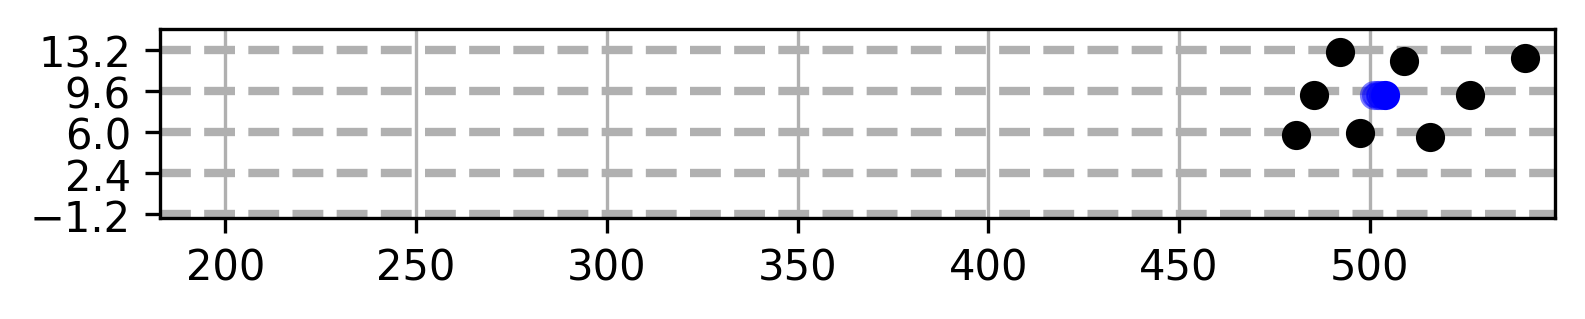

In [57]:
test_set = STP_GR_Dataset(data_path='stp_data_all/stp0805am-0820am_v337',scenario_names=['stp0805am-0820am'])
torch.set_num_threads(4)
testDataloader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
print(len(testDataloader))
len_f = len(vid_traj)
frms_pos = np.zeros([len_f,9,2])
# print(frms_pos.shape)
for i, data in enumerate(testDataloader):
    ref_pos = vid_traj[i]
    loc_pos = data.x[:,-1,:].cpu().detach().numpy()
    glb_pos = loc_pos+ref_pos
    frms_pos[i,:,:] = glb_pos

print(frms_pos.shape)

# fig, ax = plt.subplots()
# def plot_ori_pnt(x):
#     for i in range(x.shape[1]):
#         if i == 0:
#             ax.plot(x[:, i, 1], x[:, i, 0], '.b')
#         else:
#             ax.plot(x[:, i, 1], x[:, i, 0], '.k')
# plot_ori_pnt(frms_pos)
frms_pos = frms_pos * 0.3048
print(frms_pos)


duration = 26

fig, ax = plt.subplots(dpi=300)
ax.set_aspect(3)
# plt.ylim(-1.2, 13.2)
major_ticks = np.arange(-1.2, 15, 3.6)
# minor_ticks = np.arange(-9, 9, 1.8)


# ax.set_yticks(minor_ticks, minor=True)
def make_frame(t):
    # print(t)
    t = int(10*t)
    ax.clear()
    for i in range(9):
        if i == 0:
            ax.plot(frms_pos[t-3:t,i,1],frms_pos[t-3:t,i,0],'ob',alpha=0.5)
            ax.plot(frms_pos[t,i,1],frms_pos[t,i,0],'ob')
        else:
            # ax.plot(frms_pos[t-3:t,i,1],frms_pos[t-3:t,i,0],'ok',alpha=0.5)
            ax.plot(frms_pos[t,i,1],frms_pos[t,i,0],'ok')
    ax.set_ylim(-1.5, 15)
    ax.set_xlim(600* 0.3048, 1800* 0.3048)
    ax.set_yticks(major_ticks)
    ax.grid(axis='y', linestyle='--', linewidth=2, which='major')
    ax.grid(axis='x')
    # plt.show()
    return mplfig_to_npimage(fig)
# make_frame(0)
animation = VideoClip(make_frame, duration=duration)
animation.write_videofile("imgs/my_animation.mp4", fps=10)
# for i, data in enumerate(testDataloader):
#     print(data.x[:,-1,:])
#     # down-sampling data
#     data.x = data.x[:, ::2, :]
#     data.y = data.y[:, 4::5, :]